In [ ]:
import math
#%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import json
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.applications.resnet_v2 import decode_predictions
from IPython.display import Image, display
from IPython.display import Image, display
import keras

In [38]:
%cd /content/drive/m

'/content'

In [ ]:
# TODO reception field size
# TODO does not work for inception deeper layers

In [ ]:
# layer_name = "conv3_block4_out"
# model = tf.keras.applications.ResNet50V2(weights="imagenet", include_top=False)
layer_name = "mixed3"
model = tf.keras.applications.InceptionV3(weights="imagenet", include_top=False)
layer = model.get_layer(name=layer_name)
activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=layer.output)


In [ ]:
activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=layer.output)

In [ ]:
img_size = 180
img = initialize_image(img_size)
direction_index = 1

NameError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
acts = activation_model(img)

In [ ]:
filter_activation = acts[:, 2:-2, 2:-2, direction_index]
loss = -tf.reduce_mean(filter_activation)

0
tf.Tensor(-0.0, shape=(), dtype=float32)


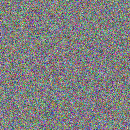

In [ ]:
loss, img, processed_img = visualize_filter_Adam(100, n_iter=100)
print(loss)
keras.preprocessing.image.save_img("0.png", processed_img)
display(Image("0.png"))

In [ ]:
activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=layer.output)

# TODO tf.function
def compute_loss(input_image, direction_index):
    activation = activation_model(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, direction_index]
    return -tf.reduce_mean(filter_activation)

def initialize_image(img_size):
    # We start from a gray image with some random noise
    img = tf.Variable(tf.random.normal([1, img_size, img_size, 3], 0, 0.01, tf.float32, seed=1))
    # ResNet50V2 expects inputs in the range [-1, +1].
    return img


def gradient_ascent_step_Adam(img, direction_index, learning_rate, opt):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, direction_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    opt.apply_gradients(zip([grads], [img]))
    loss = compute_loss(img, direction_index)
    return loss, img

def visualize_filter_Adam(direction_index, img_size=180, learning_rate=0.1, n_iter=100):
    # gradient ascent
    img = initialize_image(img_size)
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    for i in range(n_iter):
        loss, img = gradient_ascent_step_Adam(img, direction_index, learning_rate, opt)
        # Progress
        if (i % 100 == 0):
            print(i)
    # Decode the resulting input image
    processed_img = deprocess_image(img[0].numpy())
    return loss, img, processed_img

def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [ ]:
direction_index=15
activation = activation_model(img)
# We avoid border artifacts by only involving non-border pixels in the loss.
filter_activation = activation[:, 2:-2, 2:-2, direction_index]
print(-tf.reduce_mean(filter_activation))

tf.Tensor(-55953.31, shape=(), dtype=float32)


In [ ]:
all_imgs = []
for filter_index in range(64):
    print("Processing filter %d" % (filter_index,))
    loss, img = visualize_filter(filter_index)
    all_imgs.append(img)

# Build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# Fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img = all_imgs[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = img
keras.preprocessing.image.save_img("stiched_filters.png", stitched_filters)

from IPython.display import Image, display

display(Image("stiched_filters.png"))

In [ ]:
activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=layer.output)

def compute_loss(input_image, direction_index):
    activation = activation_model(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, direction_index]
    return -tf.reduce_mean(filter_activation)

@tf.function
def gradient_ascent_step(img, direction_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, direction_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img -= learning_rate * grads
    return loss, img

# Compute image inputs that maximize per-filter activations
def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.normal([1, img_width, img_height, 3], 0, 0.01, tf.float32, seed=1)#tf.Variable()
    # ResNet50V2 expects inputs in the range [-1, +1].
    return img

def visualize_filter(direction_index, learning_rate= 0.1, n_iter = 100):
    # We run gradient ascent for 20 steps
    n_iter = 1000
    learning_rate = 50
    img = initialize_image()
    for iteration in range(n_iter):
        loss, img = gradient_ascent_step(img, direction_index, learning_rate)
        print(loss)
    # Decode the resulting input image
    processed_img = deprocess_image(img[0].numpy())
    return loss, img, processed_img, 

def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [ ]:
loss, img, processed_img = visualize_filter(15)
print(loss)
keras.preprocessing.image.save_img("0.png", processed_img)
display(Image("0.png"))

tf.Tensor(0.820531, shape=(), dtype=float32)
tf.Tensor(0.53486705, shape=(), dtype=float32)
tf.Tensor(-0.9194194, shape=(), dtype=float32)
tf.Tensor(-2.1951158, shape=(), dtype=float32)
tf.Tensor(-3.3649578, shape=(), dtype=float32)
tf.Tensor(-4.4054213, shape=(), dtype=float32)
tf.Tensor(-5.374236, shape=(), dtype=float32)
tf.Tensor(-6.3499393, shape=(), dtype=float32)
tf.Tensor(-7.24808, shape=(), dtype=float32)
tf.Tensor(-8.155781, shape=(), dtype=float32)
tf.Tensor(-9.086887, shape=(), dtype=float32)
tf.Tensor(-9.973441, shape=(), dtype=float32)
tf.Tensor(-10.832006, shape=(), dtype=float32)
tf.Tensor(-11.652586, shape=(), dtype=float32)
tf.Tensor(-12.5981655, shape=(), dtype=float32)
tf.Tensor(-13.47094, shape=(), dtype=float32)
tf.Tensor(-14.435376, shape=(), dtype=float32)
tf.Tensor(-15.345544, shape=(), dtype=float32)
tf.Tensor(-16.284485, shape=(), dtype=float32)
tf.Tensor(-17.24514, shape=(), dtype=float32)
tf.Tensor(-18.217243, shape=(), dtype=float32)
tf.Tensor(-19.241568, 

KeyboardInterrupt: ignored

In [ ]:
direction_index=0
activation = activation_model(img[None])
# We avoid border artifacts by only involving non-border pixels in the loss.
filter_activation = activation[:, 2:-2, 2:-2, direction_index]
print(tf.reduce_mean(filter_activation))

tf.Tensor(-626.1025, shape=(), dtype=float32)


In [ ]:
-compute_loss(img[None], direction_index)

<tf.Tensor: shape=(), dtype=float32, numpy=-605.5603>